In [56]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 48, number of threads: 6, number of workers: 8


In [2]:
client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
client

Client Scheduler: tcp://127.0.0.1:46111 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 515.40 GB


# Intake to load CMIP data

### Using intake-esm on mistral
- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/home/mpim/m300524/intake-esm-datastore/catalogs` or `https://github.com/NCAR/intake-esm-datastore/` and skip long catalog building process of running `/home/mpim/m300524/intake-esm-datastore/builders/*.ipynb`

In [3]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pprint
warnings.simplefilter("ignore")
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake_esm
intake_esm.__version__

'2019.8.23.post95'

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [4]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

# CMIP6

In [18]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [24]:
variable='fgco2'
query = dict(experiment_id=['esm-piControl'], table_id='Omon', 
             variable_id=variable, grid_label=['gn', 'gr'])
cat = col.search(**query)

print(cat.df['source_id'].unique())

['GFDL-ESM4' 'CanESM5' 'CESM2' 'CNRM-ESM2-1']


In [20]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}},
                                preprocess=combined_preprocessing)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)


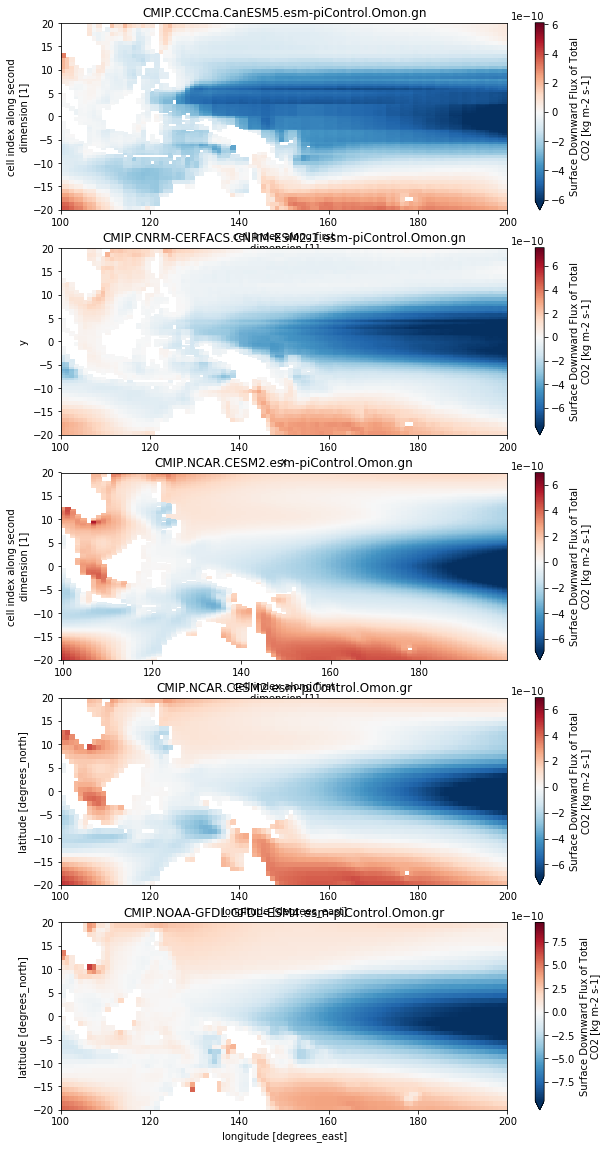

In [38]:
fig, axarr = plt.subplots(nrows=len(dset_dict), figsize=[10,4*len(dset_dict)])
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    # time mean plot
    ds[variable].mean('time').sel(x=slice(100, 200), y=slice(-20,20)).plot(ax=ax, robust=True)
    ax.set_title(k)

# CMIP5

In [5]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-cmip5.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

,product_id,institute,model,experiment,frequency,modeling_realm,mip_table,ensemble_member,variable,temporal_subset,version,path
0,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19991201-20041130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
1,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,20041201-20051130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
2,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19791201-19841130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
3,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19591201-19641130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...
4,output1,MOHC,HadGEM2-CC,historical,day,atmos,day,r2i1p1,rhs,19841201-19891130,v20111129,/work/kd0956/CMIP5/data/cmip5/output1/MOHC/Had...


In [7]:
uni_dict = col.unique(['model', 'institute', 'mip_table','experiment'])
pprint.pprint(uni_dict, compact=True)

{'experiment': {'count': 101,
                'values': ['historical', 'piControl', 'rcp85', 'midHolocene',
                           'rcp45', 'amip4K', 'aqua4xCO2', 'sstClim',
                           'sstClimAerosol', 'sstClimSulfate', 'amip4xCO2',
                           'amip', 'sstClim4xCO2', 'aqua4K', 'aquaControl',
                           'amipFuture', 'decadal2001', 'decadal1982',
                           'decadal1961', 'decadal2003', 'decadal1973',
                           'decadal1963', 'decadal1975', 'decadal1996',
                           'decadal2005', 'decadal2000', 'decadal1988',
                           'decadal2002', 'decadal1972', 'decadal1977',
                           'decadal2008', 'decadal1986', 'decadal1968',
                           'decadal1999', 'decadal1967', 'decadal1992',
                           'decadal1990', 'decadal1978', 'decadal1960',
                           'decadal1984', 'decadal1976', 'decadal1980',
                       

In [8]:
dset_dict = col.search(experiment='esmControl',variable='fgco2').to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'

--> There will be 14 group(s)


In [31]:
ds = dset_dict['MPI-M.MPI-ESM-LR.esmControl.Omon']['fgco2'].squeeze().load()

# MiKlip
MiKlip data is cmorized based on `CMIP5` conventions.
The following catalog `col` contains output from 5 `generation`s of MiKlip output from `/work/bmx828/miklip-ces/data4miklip/model/global/miklip/`.

- Marotzke, Jochem, Wolfgang A. Müller, Freja S. E. Vamborg, Paul Becker, Ulrich Cubasch, Hendrik Feldmann, Frank Kaspar, et al. “MiKlip: A National Research Project on Decadal Climate Prediction.” Bulletin of the American Meteorological Society 97, no. 12 (June 17, 2016): 2379–94. https://doi.org/10/gddfck.


In [12]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-miklip.json"
col = intake.open_esm_datastore(col_url)
col.df.head()

,generation,product_id,institute,model,experiment,frequency,modeling_realm,mip_table,ensemble_member,variable,temporal_subset,version,path
0,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,sfcWind,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
1,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,tas,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
2,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,psl,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
3,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,pr,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...
4,baseline0,output1,MPI-M,MPI-ESM-LR,decadal2001,day,atmos,day,r2i1p1,tasmin,20020101-20111231,v20111122,/work/bmx828/miklip-ces/data4miklip/model/glob...


In [13]:
col.df.nunique()

generation               6
product_id               4
institute                4
model                    5
experiment             402
frequency                8
modeling_realm           7
mip_table               21
ensemble_member         93
variable               276
temporal_subset       2727
version                 22
path               1773282
dtype: int64

In [14]:
import pprint
uni_dict = col.unique(['generation', 'product_id','variable'])
pprint.pprint(uni_dict, compact=True)

{'generation': {'count': 7,
                'values': ['baseline0', 'baseline1', 'preop-dcpp', nan, 'preop',
                           'miklip', 'prototype']},
 'product_id': {'count': 5,
                'values': ['output1', 'output', 'miklip-extra', nan, 'preop']},
 'variable': {'count': 277,
              'values': ['sfcWind', 'tas', 'psl', 'pr', 'tasmin', 'tasmax',
                         'omldamax', 'tossq', 'tos', 'rsdt', 'prw', 'clivi',
                         'fco2nat', 'ps', 'vas', 'tauu', 'rlut', 'hur',
                         'rsdscs', 'rsuscs', 'tauv', 'rlutcs', 'evspsbl', 'va',
                         'rlus', 'uas', 'cl', 'rsut', 'tro3', 'ta', 'prsn',
                         'prc', 'rsds', 'rtmt', 'rsus', 'ua', 'co2mass', 'clw',
                         'rlds', 'rldscs', 'hfls', 'clt', 'cct', 'clwvi', 'hus',
                         'zg', 'wap', 'cli', 'rsutcs', 'ts', 'hfss', 'snc',
                         'snw', 'snm', 'zossga', 'tauvo', 'pbo', 'tauuo',
           

In [37]:
cat = cat = col.search(model='MPI-ESM-LR',variable='tas',frequency='mon',
                 ensemble_member=['r1i1p1','r2i1p1','r3i1p1'],experiment=['decs4e1991','decs4e1992','decadal1991','decadal1992'])

In [26]:
#col.search(generation='baseline1').df.variable.unique()

In [38]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*5}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'

--> There will be 4 group(s)


In [44]:
ds = xr.concat([i['tas'].squeeze().mean('ensemble_member') for i in dset_dict.values()],'run')
ds['run']=list(dset_dict.keys())

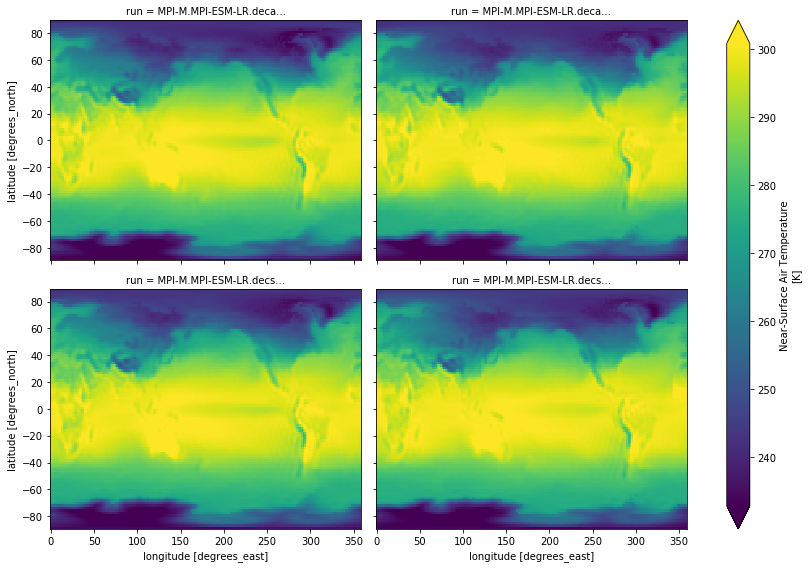

In [54]:
# plot one target timestep: Feb 93
ds.sel(time='1993-02').squeeze().plot(col='run',col_wrap=2,robust=True,figsize=(12,8))